In [1]:
import pandas as pd
import tqdm
import numpy as np
from sklearn.linear_model import LinearRegression
from collections import defaultdict
import os
import pickle

import osmnx as ox

import gspread
from oauth2client.service_account import ServiceAccountCredentials
import google_streetview.api

# Network of Boston

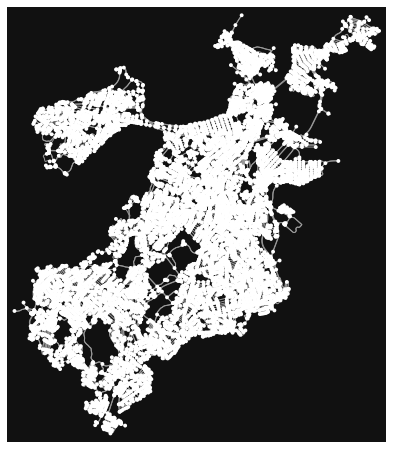

In [3]:
# Fetch OSM street network from the location
beacon_hill = ox.graph_from_place('Boston, MA', network_type='drive')

# clean up the intersections and extract their xy coords
beacon_hill = ox.project_graph(beacon_hill)
bh_intersections = ox.consolidate_intersections(beacon_hill, tolerance=15, dead_ends=False)
bh_intersection_nodes, bh_intersection_edges = ox.graph_to_gdfs(bh_intersections)
bh_intersection_nodes = bh_intersection_nodes[~bh_intersection_nodes.lon.isnull()]

# Plot the streets
fig, ax = ox.plot_graph(beacon_hill)

<h3>Map ox points to GPS coordinates</h3>

In [4]:
node2gps = dict(zip(bh_intersection_nodes['osmid_original'], bh_intersection_nodes[['lat','lon']].values.tolist()))

In [5]:
# Build mapping of ox coordinate space -> GPS coordinate space (parallel lists)
ox_pts = []
gps_pts = []
for i,(_,row) in tqdm.tqdm(enumerate(bh_intersection_edges.iterrows())):    
    if row.u_original in node2gps:
        ox_pts.append(  (row.geometry.xy[0][0], row.geometry.xy[1][0]) )
        gps_pts.append( node2gps[row.u_original] )

    if row.v_original in node2gps:
        ox_pts.append(  (row.geometry.xy[0][-1], row.geometry.xy[1][-1]) )
        gps_pts.append( node2gps[row.v_original] )

# list-to-array (for sklearn)
gps_mat = np.array(gps_pts)

19439it [00:03, 5014.99it/s]


In [6]:
# Learn the 2d -> 2d mapping which allows converting ox coordinates to GPS coordinates
lr_gps = LinearRegression()
lr_gps.fit(ox_pts, gps_mat)

def ox_to_gps(ox_coord):
    coord  =  lr_gps.predict([ox_coord])[0]
    return coord

# Which nodes to query?

In [7]:
def euclidian(a, b):
    c2 = (a[0]-b[0])**2 + (a[1]-b[1])**2
    return c2 ** 0.5

In [8]:
def find_bucket(buckets, val):
    if val < min(buckets):
        return 0
    for i,b in enumerate(buckets):
        if val <= b:
            return i
    return len(buckets)


In [9]:
# There are too many points to query, so create a 271x301 grid (only query 1 point per grid space)
minlat = float('inf')
minlon = float('inf')
maxlat = float('-inf')
maxlon = float('-inf')

for i,row in tqdm.tqdm(enumerate(bh_intersection_edges.itertuples())):
    pts = np.array(row.geometry.xy)
    for j in range(pts.shape[1]):
        pt_ox = pts[:,j]
        pt_gps = tuple(ox_to_gps(pt_ox))
        minlat = min(minlat, pt_gps[0])
        minlon = min(minlon, pt_gps[1])
        
        maxlat = max(maxlat, pt_gps[0])
        maxlon = max(maxlon, pt_gps[1])
        

step_size = 0.0006
num_steps_lat = (maxlat-minlat)/step_size + 1
num_steps_lon = (maxlon-minlon)/step_size + 1

19439it [00:07, 2499.72it/s]


In [11]:
lat_buckets = list(np.arange(num_steps_lat) * step_size + minlat)
lon_buckets = list(np.arange(num_steps_lon) * step_size + minlon)
grid = defaultdict(list)

for i,row in tqdm.tqdm(enumerate(bh_intersection_edges.itertuples())):
    #if i>= 5: break
        
    pts = np.array(row.geometry.xy)
    for j in range(pts.shape[1]):
        pt_ox = pts[:,j]
        pt_gps = tuple(ox_to_gps(pt_ox))
        #print(pt_gps)
        latb = find_bucket(lat_buckets, pt_gps[0])
        lonb = find_bucket(lon_buckets, pt_gps[1])
        
        grid[(latb,lonb)].append(pt_gps)
        
        #print(latb, lonb)
        #print()
        
    #break

19439it [00:10, 1821.76it/s]


In [12]:
# Identify which ~7000 GPS coordinates to query (traverse non-residential streets and only one point per grid)

seen = set()
query_pts = []
for i,row in tqdm.tqdm(enumerate(bh_intersection_edges.itertuples())):
    if row.highway in ['primary', 'secondary', 'tertiary']:
        pts = np.array(row.geometry.xy)
        for j in range(pts.shape[1]):
            pt_ox = pts[:,j]
            pt_gps = tuple(ox_to_gps(pt_ox))
            latb = find_bucket(lat_buckets, pt_gps[0])
            lonb = find_bucket(lon_buckets, pt_gps[1])
            key = (latb,lonb)
            if key in seen: continue
            seen.add(key)

            #print(pt_gps)
            query_pts.append(pt_gps)


print(len(query_pts))


19439it [00:04, 4681.53it/s]

7146


# Query These Points

In [13]:
# Load metadata about the existing images
metadata_pkl = 'gsv/metadata.pkl'
if os.path.exists(metadata_pkl):
    with open(metadata_pkl, 'rb') as f:
        metadata = pickle.load(f)
else:
    metadata = {}
    
print(len(metadata))

44356


In [24]:
def query_gsv_api(params):
    # TODO: gracefully fail if params is ill-formatted
    pass

    #print(params)
    #1/0
    
    #print(params)
    cparams = dict(params)
    if 'notes' in cparams: del cparams['notes']
    if 'metadata' in cparams: del cparams['metadata']
    
    # Check for cached result
    for k,vals in metadata.items():
        cvals = dict(vals)
        if 'notes' in cvals: del cvals['notes']
        if 'metadata' in cvals: del cvals['metadata']
        if cvals==cparams:
            return k
        
    # Download the image
    results = google_streetview.api.results([cparams])
    params['metadata'] = results.metadata

    # Move the downloaded data into a cached folder

    # Download images to directory 'downloads'
    results.download_links('downloads')

    next_id = len(metadata) + 1

    # move the photo
    os.rename('downloads/gsv_0.jpg', f'gsv/image{next_id:04}.jpg')
    print('\tsuccess:', params)

    # save metadata of query
    metadata[next_id] = params

    # update the metadata
    with open(metadata_pkl, 'wb') as f:
        pickle.dump(metadata, f)
        
    return next_id

In [31]:
def gps_search(lat, long, notes=''):
    ids = []
    for i in range(6):
        # Define parameters for street view api
        params = {
            'size': '640x320',
            'location': f'{lat},{long}',
            'pitch': '15',
            'heading': f'{60*i}',
            'fov':'60',
            'key': 'xxx' # (wboag) TODO: you need to add your own API key
        }
        
        if len(notes): params['notes'] = notes

        k = query_gsv_api(params)
        ids.append(k)
    return ids

In [32]:
def show_image(image_id, show_metadata=False):
    if show_metadata:
        display(metadata[image_id])
        
    path = f'gsv/image{image_id:04}.jpg'
    img = cv2.imread(path)
    fig = pl.figure(figsize=(17,9))
    img = img[:, :, ::-1]
    pl.imshow(img)
    pl.show()

In [34]:
coords = set()
images = []
camera_images = []
for i,(coord) in tqdm.tqdm(enumerate(query_pts)):
    if i>= 5:
        print('Remove this if you want to run the full (approx 42,000 image) query')
        break
        
    if coord in coords: continue
    coords.add(coord)
    
    lat,long = coord
    notes = ''
    ids = gps_search(lat, long, notes)
    images += ids
    camera_images.append((i,coord,ids))
    #print(ids)
    #for image_id in ids:
    #    print()
    #    print(image_id)
    #    show_image(image_id, show_metadata=True)
    
    #if i>=500: break

5it [00:00,  5.66it/s]

Remove this if you want to run the full (approx 42,000 image) query
